## Imports

All the libraries and utilities we use across Tasks 1–5.


In [17]:
# ─── Standard library ───────────────────────────────────────────────────────────
import os
import json
import random

# ─── Numerical computing ────────────────────────────────────────────────────────
import numpy as np

# ─── PyTorch core ───────────────────────────────────────────────────────────────
import torch
import torch.nn as nn
import torch.nn.functional as F

# ─── TorchVision ───────────────────────────────────────────────────────────────
from torchvision import datasets, models, transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import save_image

# ─── Data loading ──────────────────────────────────────────────────────────────
from torch.utils.data import DataLoader, Dataset

# ─── Image handling ───────────────────────────────────────────────────────────
from PIL import Image

# ─── Visualization ─────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

# ─── Progress bar ──────────────────────────────────────────────────────────────
from tqdm import tqdm

## Task 1: Baseline Evaluation

In this task we load a pre-trained ResNet-34, prepare the ImageNet subset, build the label mapping, and compute top-1 and top-5 accuracy.


1. Load Pre-trained Model

In [18]:
# Load ResNet-34 with ImageNet-1K V1 weights and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

2. Define Transforms & Load Dataset

In [19]:
# Normalization parameters
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms  = np.array([0.229, 0.224, 0.225])

# Compose transforms: to tensor + normalize
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Path to the 100-class test subset
dataset_path = "/content/drive/MyDrive/NYU CS/Deep Learning/project3/TestDataSet"

# Load the images from folder structure
dataset = datasets.ImageFolder(root=dataset_path,
                               transform=plain_transforms)

# Quick sanity check
print(dataset.classes[:20])   # first 20 synsets
print("Total", len(dataset.classes), "classes")


['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877', 'n02699494', 'n02701002', 'n02704792', 'n02708093', 'n02727426', 'n02730930', 'n02747177', 'n02749479', 'n02769748', 'n02776631', 'n02777292', 'n02782093', 'n02783161', 'n02786058', 'n02787622']
Total 100 classes


3. Read labels_list.json & Build Mapping

In [20]:
# Get folder synsets
synsets = dataset.classes

# Load the JSON list: ["0: accordion", "1: acoustic guitar", ...]
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    label_list = json.load(f)

# Extract only class names
json_classnames = [x.split(": ")[1] for x in label_list]

print("First 5 folder synsets:", synsets[:5])
print("First 5 JSON class names:", json_classnames[:5])

# Build reverse map: name → string index
r_label_list = {name: idx_str for (idx_str, name) in
                (e.split(": ",1) for e in label_list)}

# Construct numeric_labels: global ImageNet indices for each folder class
numeric_labels = []
for syn, name in zip(synsets, json_classnames):
    numeric_labels.append(int(r_label_list[name]))

print("First 5 numeric labels:", numeric_labels[:5])


First 5 folder synsets: ['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877']
First 5 JSON class names: ['accordion', 'acoustic guitar', 'aircraft carrier', 'airliner', 'airship']
First 5 numeric labels: [401, 402, 403, 404, 405]


4. Compute Baseline Top-1 / Top-5 Accuracy

In [21]:
# Utility to compute top-k accuracy
def compute_topk_accuracy(outputs, targets, topk=(1,5)):
    maxk = max(topk)
    batch_size = targets.size(0)

    _, pred = outputs.topk(maxk, dim=1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    res = {}
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res[k] = (correct_k.item() * 100.0) / batch_size
    return res

# Create DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

# Accumulate accuracy
sum1 = sum5 = n = 0
model.eval()
with torch.no_grad():
    for imgs, folder_idxs in loader:
        imgs = imgs.to(device)
        # Map folder index (0–99) to global 0–999 labels
        targets = torch.tensor(
            [numeric_labels[i] for i in folder_idxs.tolist()],
            dtype=torch.long, device=device
        )

        outputs = model(imgs)
        acc = compute_topk_accuracy(outputs, targets, topk=(1,5))
        bsz = targets.size(0)
        sum1 += acc[1] * bsz / 100.0
        sum5 += acc[5] * bsz / 100.0
        n   += bsz

# Final metrics
baseline_top1 = 100.0 * sum1 / n
baseline_top5 = 100.0 * sum5 / n
print(f"Baseline Top-1: {baseline_top1:.2f}%")
print(f"Baseline Top-5: {baseline_top5:.2f}%")


Baseline Top-1: 76.00%
Baseline Top-5: 94.20%


## Task 2: Pixel-wise Attack (FGSM)
In this task we prepare the data, build the label mapping, and define all the attack and utility functions we’ll need for FGSM (and later PGD) attacks.

### 1. Preprocessing Transforms

In [22]:
# resize→crop→to_tensor (for adversarial generation)
RAW_TRANSFORM = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# to_tensor→normalize (for evaluation)
NORM_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

2. Label Mapping

In [23]:
# 1) load the dataset folder structure
_ds = datasets.ImageFolder(dataset_path, transform=RAW_TRANSFORM)

# 2) read the "idx: class" list
_entries = json.load(open(os.path.join(dataset_path, "labels_list.json")))

# 3) split into (synset, idx_str)
_pairs = [e.split(": ", 1) for e in _entries]

# 4) build synset → global ImageNet idx map
_syn2idx = {syn: int(idx) for idx, syn in _pairs}

# 5) create a 500-long list of global labels
numeric_labels = numeric_labels


3. Utility & Attack Functions
3.1 Top-k Accuracy

In [24]:
def compute_topk_accuracy(outputs: torch.Tensor,
                          targets: torch.Tensor,
                          topk=(1,5)) -> dict:
    """Return {k: accuracy%} for each k in topk."""
    maxk = max(topk)
    batch_size = targets.size(0)

    _, pred = outputs.topk(maxk, dim=1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    res = {}
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res[k] = (correct_k.item() * 100.0) / batch_size
    return res


3.2 FGSM Attack

In [25]:
def fgsm_attack(model, x: torch.Tensor, y: torch.Tensor,
                epsilon: float, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """
    Single-step FGSM: x in [0,1], y is global ImageNet label.
    """
    x_adv = x.clone().detach().to(mean.device)
    x_adv.requires_grad_()
    logits = model((x_adv - mean)/std)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    return torch.clamp(x_adv + epsilon * x_adv.grad.sign(), 0.0, 1.0).detach()


3.3 Adversarial Dataset

In [26]:
class AdvDataset(Dataset):
    """Load adversarial PNGs + their labels from a folder."""
    def __init__(self, image_dir, labels, transform):
        self.files = sorted(os.listdir(image_dir))
        self.dir   = image_dir
        self.labels= labels
        self.transform = transform

    def __len__(self): return len(self.labels)

    def __getitem__(self, i):
        path = os.path.join(self.dir, self.files[i])
        img  = Image.open(path).convert("RGB")
        return self.transform(img), self.labels[i]


3.4 PGD Attack

In [27]:
def pgd_attack(model, x: torch.Tensor, y: torch.Tensor,
               epsilon: float, alpha: float, iters: int,
               mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """Multi-step PGD attack on full image."""
    x_adv, x_orig = x.clone().detach(), x.clone().detach()
    for _ in range(iters):
        x_adv.requires_grad_()
        logits = model((x_adv - mean)/std)
        F.cross_entropy(logits, y).backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        x_adv = torch.max(torch.min(x_adv, x_orig + epsilon),
                          x_orig - epsilon)
        x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()
    return x_adv


3.5 PGD Patch Attack

In [28]:
def pgd_patch_attack(model, x: torch.Tensor, y: torch.Tensor,
                     epsilon: float, alpha: float, iters: int,
                     mean: torch.Tensor, std: torch.Tensor,
                     patch_size: int,
                     random_patch: bool=False) -> torch.Tensor:
    """PGD attack restricted to a single patch of size patch_size."""
    x_adv, x_orig = x.clone().detach(), x.clone().detach()
    B, C, H, W = x.shape
    if random_patch:
        top  = torch.randint(0, H-patch_size+1, (1,)).item()
        left = torch.randint(0, W-patch_size+1, (1,)).item()
    else:
        top  = (H-patch_size)//2
        left = (W-patch_size)//2
    mask = torch.zeros_like(x_adv)
    mask[:, :, top:top+patch_size, left:left+patch_size] = 1

    for _ in range(iters):
        x_adv.requires_grad_()
        logits = model((x_adv - mean)/std)
        F.cross_entropy(logits, y).backward()
        grad = x_adv.grad.sign()
        x_adv = x_adv + alpha * grad * mask
        x_adv = torch.max(torch.min(x_adv, x_orig + epsilon*mask),
                          x_orig - epsilon*mask)
        x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()
    return x_adv


### 4. Generate Adversarial Examples with FGSM
In this step we iterate over the clean images, apply the FGSM attack to each one, save the perturbed images, and collect a few examples where the model flips its prediction.


In [29]:
# Setup
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon    = 0.02
dataset_pa = dataset_path
adv_dir    = "/content/drive/MyDrive/NYU CS/Deep Learning/project3/Adversarial_Test_Set_1"
os.makedirs(adv_dir, exist_ok=True)

# DataLoader for raw images
raw_ds = datasets.ImageFolder(dataset_pa, transform=RAW_TRANSFORM)
loader = DataLoader(raw_ds, batch_size=1, shuffle=False, num_workers=4)

# Normalization tensors for the attack
mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)

# Load model
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = model.to(device).eval()

max_linf    = 0.0
mis_examples = []

for idx, (img, folder_idx) in enumerate(tqdm(loader)):
    img      = img.to(device)
    true_idx = numeric_labels[folder_idx.item()]
    y        = torch.tensor([true_idx], device=device)

    # Perform FGSM attack
    adv = fgsm_attack(model, img, y, epsilon, mean, std)

    # Track L∞ distance
    linf = (adv - img).abs().max().item()
    max_linf = max(max_linf, linf)
    assert linf <= epsilon + 1e-6, f"L∞={linf:.5f} > ε"

    # Save adversarial image
    save_path = os.path.join(adv_dir, f"{idx:04d}.png")
    save_image(adv.cpu(), save_path)

    # Collect first 5 “correct→incorrect” examples
    if len(mis_examples) < 5:
        with torch.no_grad():
            pred_o = model((img - mean)/std).argmax(1).item()
            pred_a = model((adv - mean)/std).argmax(1).item()
        print(f"true {true_idx}, before {pred_o}, after {pred_a}")
        if pred_o == true_idx and pred_a != true_idx:
            mis_examples.append((img.cpu(), adv.cpu(), true_idx))

print(f"Maximum L∞ distance over all adversarial samples: {max_linf:.5f}")

  0%|          | 1/500 [00:01<11:37,  1.40s/it]

true 401, before 401, after 401


  0%|          | 2/500 [00:02<09:46,  1.18s/it]

true 401, before 401, after 911


  1%|          | 3/500 [00:03<09:22,  1.13s/it]

true 401, before 819, after 819


  1%|          | 4/500 [00:04<09:11,  1.11s/it]

true 401, before 401, after 584


  1%|          | 5/500 [00:05<08:53,  1.08s/it]

true 401, before 800, after 800


  1%|          | 6/500 [00:06<08:52,  1.08s/it]

true 402, before 546, after 546


  1%|▏         | 7/500 [00:07<09:24,  1.15s/it]

true 402, before 402, after 826


  2%|▏         | 8/500 [00:09<09:54,  1.21s/it]

true 402, before 402, after 546


  2%|▏         | 9/500 [00:10<10:28,  1.28s/it]

true 402, before 402, after 491


100%|██████████| 500/500 [07:09<00:00,  1.17it/s]

Maximum L∞ distance over all adversarial samples: 0.02000


### 5. Evaluate FGSM Attack Performance
Now we load the saved adversarial images, build a DataLoader, and compute top-1 and top-5 accuracy drops relative to the baseline.

In [30]:
# Build labels list: 5 images per class × 100 classes = 500 labels
expanded_labels = [numeric_labels[i] for i in range(100) for _ in range(5)]

# Dataset & DataLoader for adversarial images
adv_ds     = AdvDataset(adv_dir, expanded_labels, NORM_TRANSFORM)
adv_loader = DataLoader(adv_ds, batch_size=32, shuffle=False, num_workers=4)

# Evaluate
model.eval()
sum1 = sum5 = n = 0
with torch.no_grad():
    for x, y in adv_loader:
        x, y = x.to(device), torch.tensor(y, device=device)
        logits = model(x)  # already normalized inside fgsm_attack
        acc = compute_topk_accuracy(logits, y, topk=(1,5))
        bsz = y.size(0)
        sum1 += acc[1] * bsz / 100.0
        sum5 += acc[5] * bsz / 100.0
        n    += bsz

fgsm_top1 = 100.0 * sum1 / n
fgsm_top5 = 100.0 * sum5 / n

# Compute drop relative to baseline_top1 and baseline_top5
drop1 = (baseline_top1 - fgsm_top1) / baseline_top1 * 100
drop5 = (baseline_top5 - fgsm_top5) / baseline_top5 * 100

print(f"Baseline Top-1: {baseline_top1:.2f}%")
print(f"Baseline Top-5: {baseline_top5:.2f}%")
print(f"FGSM Top-1:     {fgsm_top1:.2f}%  (Drop {drop1:.2f}%)")
print(f"FGSM Top-5:     {fgsm_top5:.2f}%  (Drop {drop5:.2f}%)")


<ipython-input-30-93da086c4c97>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(device), torch.tensor(y, device=device)


Baseline Top-1: 76.00%
Baseline Top-5: 94.20%
FGSM Top-1:     3.00%  (Drop 96.05%)
FGSM Top-5:     18.80%  (Drop 80.04%)


## Task 3: Multi-step PGD Attack

In this task we generate a stronger adversarial set using the Projected Gradient Descent (PGD) method, then evaluate its effect on ResNet-34, and finally visualize a few “correct→incorrect” examples.


In [31]:
### 1. Setup PGD Parameters & Paths


# Directory for saving PGD adversarial images
pgd_dir = "/content/drive/MyDrive/NYU CS/Deep Learning/project3/Adversarial_Test_Set_2"
os.makedirs(pgd_dir, exist_ok=True)

# Attack hyperparameters
epsilon = 0.02
alpha   = 0.005
iters   = 10

# DataLoader for raw images using RAW_TRANSFORM
raw_ds = datasets.ImageFolder(dataset_pa, transform=RAW_TRANSFORM)
loader = DataLoader(raw_ds, batch_size=1, shuffle=False, num_workers=4)

# Containers for tracking examples
mis_examples_pgd = []
max_linf_pgd     = 0.0

### 2. Generate PGD Adversarial Samples

In [39]:
for idx, (img, folder_idx) in enumerate(tqdm(loader)):
    img      = img.to(device)
    y        = torch.tensor([numeric_labels[folder_idx.item()]], device=device)
    true_idx = y.item()

    # Run PGD attack
    adv = pgd_attack(model, img, y, epsilon, alpha, iters, mean, std)

    # Track max L-infinity perturbation
    linf = (adv - img).abs().max().item()
    max_linf_pgd = max(max_linf_pgd, linf)
    assert linf <= epsilon + 1e-6, f"PGD L∞={linf:.5f} > ε"

    # Save adversarial image
    save_path = os.path.join(pgd_dir, f"{idx:04d}.png")
    save_image(adv.cpu(), save_path)

    # Collect first 5 “correct→incorrect” cases
    if len(mis_examples_pgd) < 5:
        with torch.no_grad():
            pred_o = model((img - mean)/std).argmax(1).item()
            pred_a = model((adv - mean)/std).argmax(1).item()
        if pred_o == true_idx and pred_a != true_idx:
            mis_examples_pgd.append((img.cpu(), adv.cpu(), true_idx))

print(f"[PGD] Maximum L∞ distance: {max_linf_pgd:.5f}")


[PGD] Maximum L∞ distance: 0.02000


### 3. Evaluate PGD Attack Performance

In [38]:
# Build labels list for 500 adversarial images
expanded_labels = [numeric_labels[i] for i in range(100) for _ in range(5)]

# Dataset & DataLoader for PGD images
adv_ds_pgd = AdvDataset(pgd_dir, expanded_labels, NORM_TRANSFORM)
adv_loader = DataLoader(adv_ds_pgd, batch_size=32, shuffle=False, num_workers=4)

model.eval()
sum1 = sum5 = n = 0
with torch.no_grad():
    for x, y in adv_loader:
        x, y = x.to(device), torch.tensor(y, device=device)
        logits = model(x)  # full-image PGD already applied
        acc = compute_topk_accuracy(logits, y, topk=(1,5))
        bsz = y.size(0)
        sum1 += acc[1] * bsz / 100.0
        sum5 += acc[5] * bsz / 100.0
        n    += bsz

pgd_top1 = 100.0 * sum1 / n
pgd_top5 = 100.0 * sum5 / n

# Compute drops relative to baseline
drop1 = (baseline_top1 - pgd_top1) / baseline_top1 * 100
drop5 = (baseline_top5 - pgd_top5) / baseline_top5 * 100

print(f"PGD Top-1: {pgd_top1:.2f}%  (Drop {drop1:.2f}%)")
print(f"PGD Top-5: {pgd_top5:.2f}%  (Drop {drop5:.2f}%)")


PGD Top-1: 0.00%  (Drop 100.00%)
PGD Top-5: 0.60%  (Drop 99.36%)


### 4. Visualize a Few “Correct→Incorrect” Examples

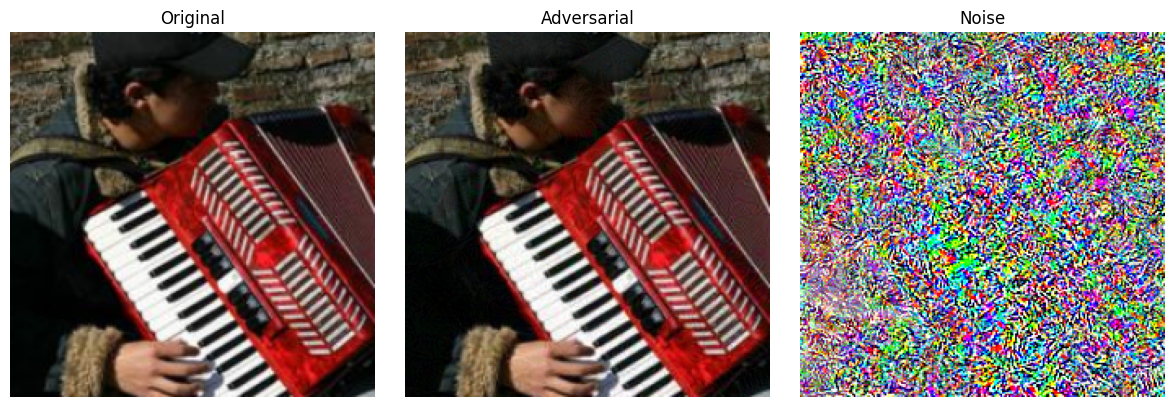

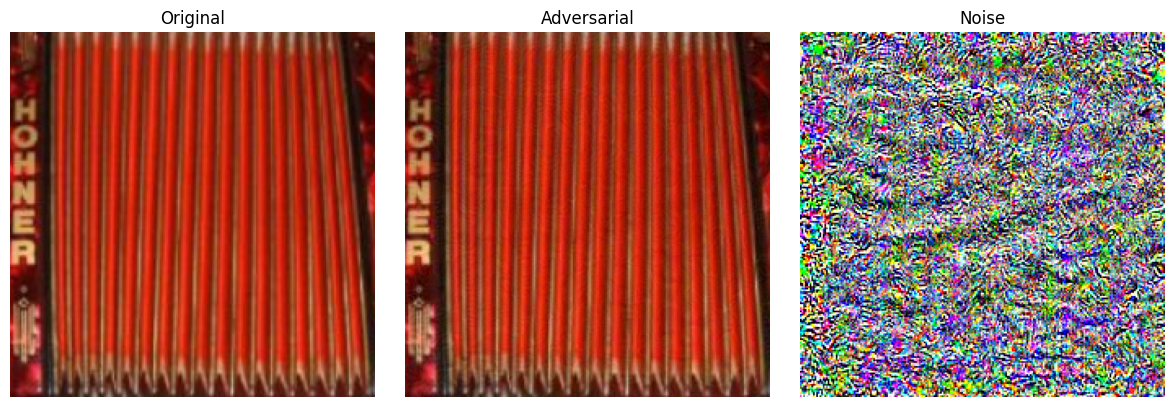

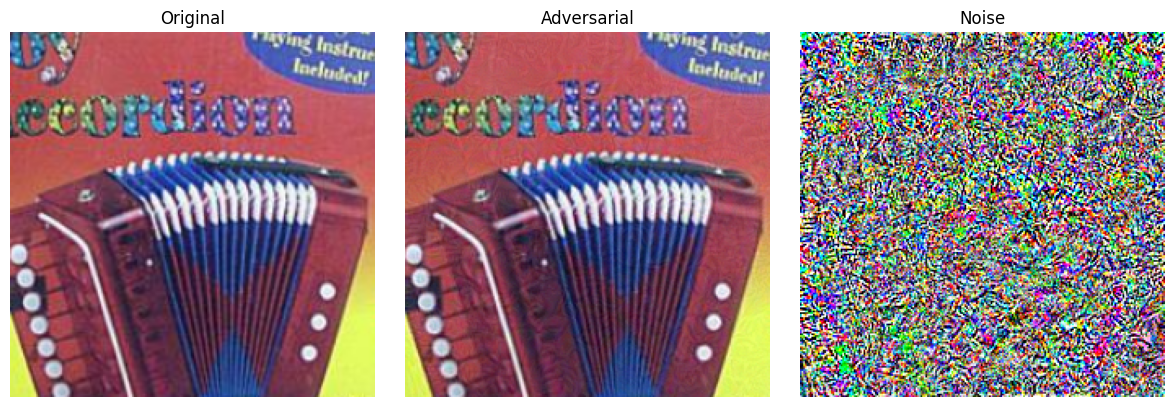

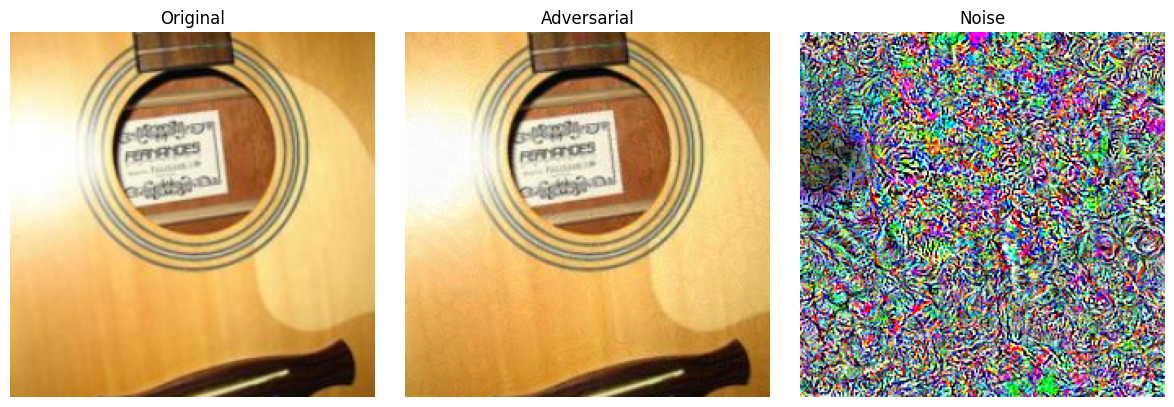

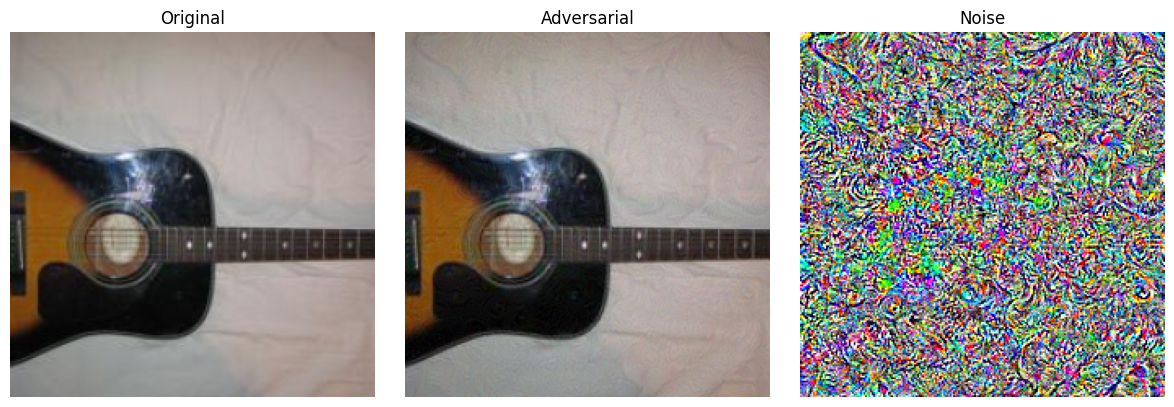

In [37]:
def visualize_attack(img_orig, img_adv, label):
    pert = img_adv - img_orig
    pert = (pert - pert.min()) / (pert.max() - pert.min() + 1e-8)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(to_pil_image(img_orig.squeeze()))
    axs[0].set_title("Original");    axs[0].axis("off")
    axs[1].imshow(to_pil_image(img_adv.squeeze()))
    axs[1].set_title("Adversarial"); axs[1].axis("off")
    axs[2].imshow(to_pil_image(pert.squeeze()))
    axs[2].set_title("Noise");       axs[2].axis("off")
    plt.tight_layout()
    plt.show()

for img_o, img_a, lbl in mis_examples_pgd:
    visualize_attack(img_o, img_a, lbl)


## Task 4: Patch-based PGD Attack

In this task we restrict the PGD attack to a small patch, generate adversarial examples, evaluate performance drop, and visualize a few cases.


### 1. Setup

In [ ]:
# Paths and hyperparameters
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon    = 0.4
alpha      = 0.025
iters      = 30
patch_size = 32

patch_dir = "/content/drive/MyDrive/NYU CS/Deep Learning/project3/Adversarial_Test_Set_3"
os.makedirs(patch_dir, exist_ok=True)

# Load model (reuse ResNet-34 from Task 1)
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = model.to(device).eval()

# Normalization tensors
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

### 2. Generate Adversarial Patches

In [40]:
# DataLoader for raw images
raw_ds = datasets.ImageFolder(dataset_pa, transform=RAW_TRANSFORM)
loader = DataLoader(raw_ds, batch_size=1, shuffle=False, num_workers=4)

mis_examples_patch = []
max_linf_patch     = 0.0

for idx, (img, folder_idx) in enumerate(tqdm(loader)):
    img    = img.to(device)
    true_idx = numeric_labels[folder_idx.item()]
    y      = torch.tensor([true_idx], device=device)

    # Run patch-constrained PGD
    adv = pgd_patch_attack(model, img, y,
                           epsilon, alpha, iters,
                           mean, std, patch_size,
                           random_patch=False)

    # Track max perturbation
    linf = (adv - img).abs().max().item()
    max_linf_patch = max(max_linf_patch, linf)

    # Save adversarial image
    save_path = os.path.join(patch_dir, f"{idx:04d}.png")
    save_image(adv.cpu(), save_path)

    # Collect first 5 “correct→incorrect” cases
    if len(mis_examples_patch) < 5:
        with torch.no_grad():
            pred_o = model((img - mean)/std).argmax(1).item()
            pred_a = model((adv - mean)/std).argmax(1).item()
        if pred_o == true_idx and pred_a != true_idx:
            mis_examples_patch.append((img.cpu(), adv.cpu(), true_idx))

print(f"[Patch] Max L∞ perturbation: {max_linf_patch:.5f}")


[Patch] Max L∞ perturbation: 0.40000


### 3. Evaluate Patch Attack

In [41]:
# Build labels list for 500 adversarial patch images
expanded_labels = [numeric_labels[i] for i in range(100) for _ in range(5)]

# Dataset & DataLoader
adv_ds_patch = AdvDataset(patch_dir, expanded_labels, NORM_TRANSFORM)
adv_loader   = DataLoader(adv_ds_patch, batch_size=32, shuffle=False, num_workers=4)

model.eval()
sum1 = sum5 = n = 0
with torch.no_grad():
    for x, y in adv_loader:
        x, y = x.to(device), torch.tensor(y, device=device)
        logits = model(x)  # no extra normalization needed here
        acc = compute_topk_accuracy(logits, y, topk=(1,5))
        bsz = y.size(0)
        sum1 += acc[1] * bsz / 100.0
        sum5 += acc[5] * bsz / 100.0
        n    += bsz

patch_top1 = 100.0 * sum1 / n
patch_top5 = 100.0 * sum5 / n

print(f"[Patch] Top-1 Accuracy: {patch_top1:.2f}%")
print(f"[Patch] Top-5 Accuracy: {patch_top5:.2f}%")


<ipython-input-41-4589d87f32b0>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(device), torch.tensor(y, device=device)


[Patch] Top-1 Accuracy: 10.00%
[Patch] Top-5 Accuracy: 38.60%


### 4. Visualize Patch Attack Examples

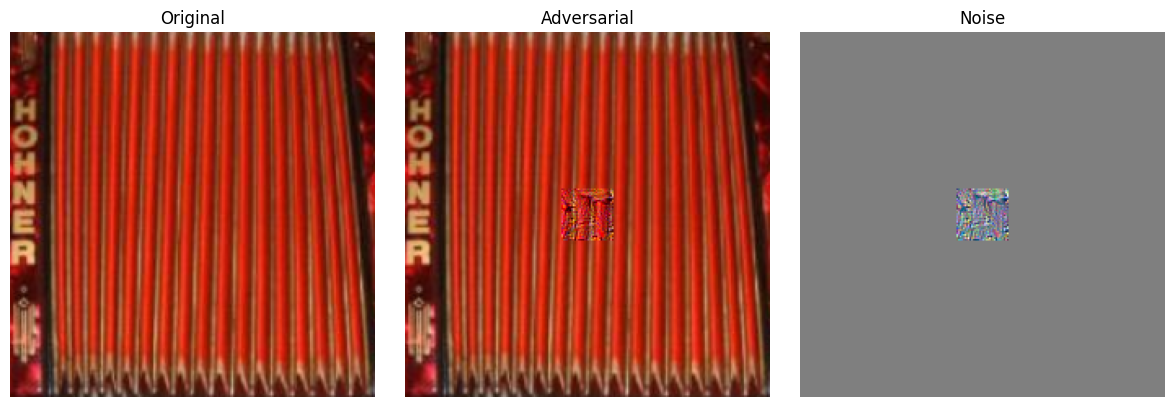

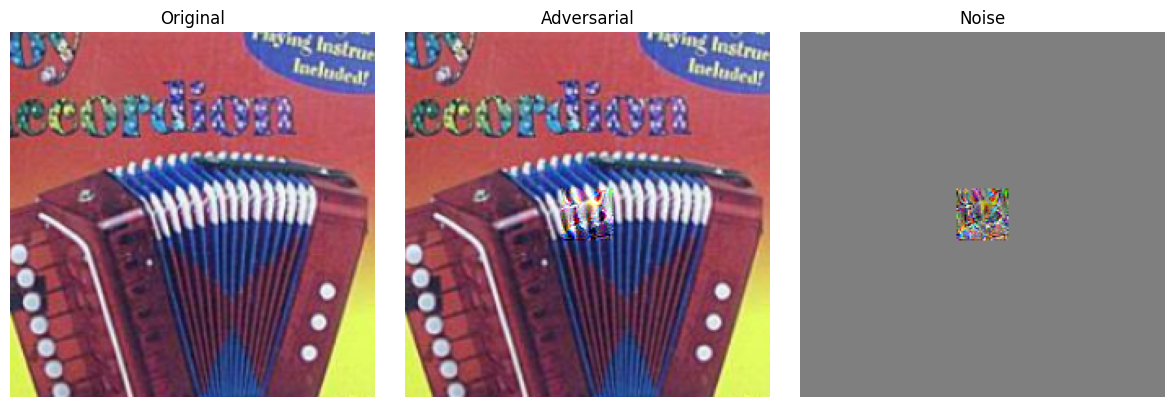

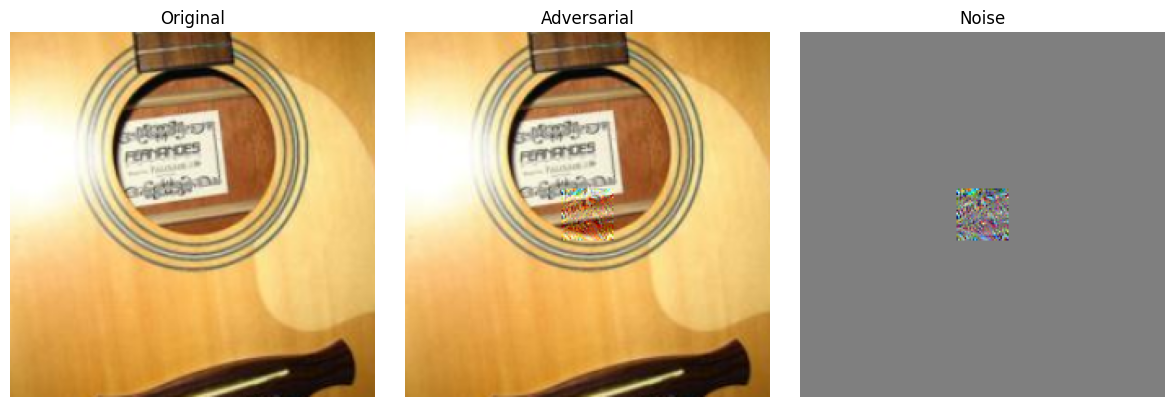

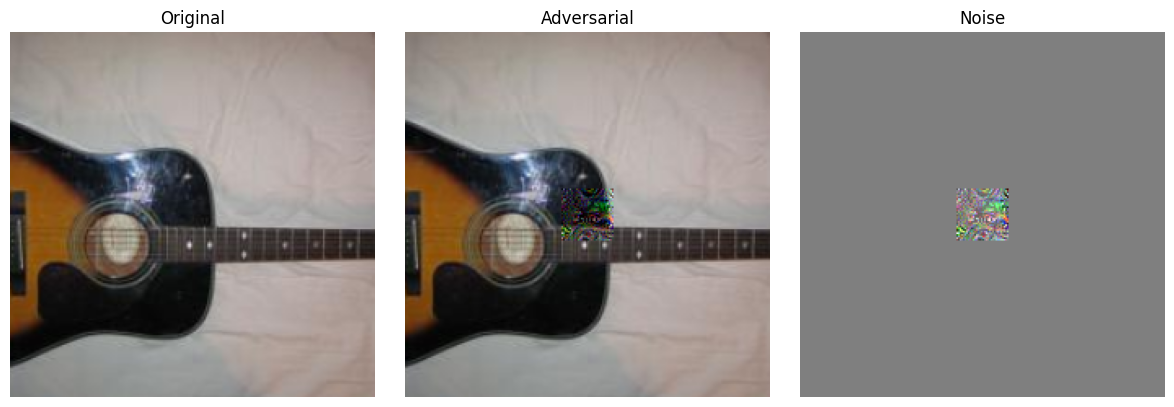

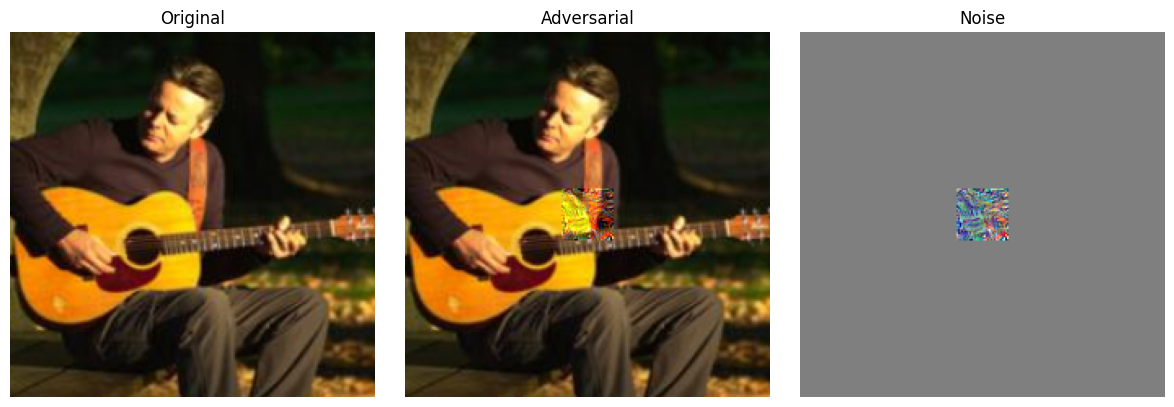

In [42]:
def visualize_attack(img_orig, img_adv, label):
    pert = img_adv - img_orig
    pert = (pert - pert.min()) / (pert.max() - pert.min() + 1e-8)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(to_pil_image(img_orig.squeeze()))
    axs[0].set_title("Original");    axs[0].axis("off")
    axs[1].imshow(to_pil_image(img_adv.squeeze()))
    axs[1].set_title("Adversarial"); axs[1].axis("off")
    axs[2].imshow(to_pil_image(pert.squeeze()))
    axs[2].set_title("Noise");       axs[2].axis("off")
    plt.tight_layout()
    plt.show()

for img_o, img_a, lbl in mis_examples_patch:
    visualize_attack(img_o, img_a, lbl)


## Task 5: Transferability of Adversarial Examples

In this task we evaluate how the adversarial sets generated in Tasks 2–4 transfer to a different model (DenseNet-121). We compute top-1 and top-5 accuracy on the original and three adversarial datasets.


### 1. Setup Device, Model, and Normalization

In [43]:
# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained DenseNet-121 and set to eval mode
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model = model.to(device).eval()

# L∞ normalization tensors
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 87.0MB/s]


### 2. Prepare Labels and Dataset Paths

In [44]:
# Global labels list (500 entries: 100 classes × 5 each)
expanded_labels = [numeric_labels[i] for i in range(100) for _ in range(5)]

# Paths to original and adversarial datasets
datasets_paths = {
    "Original":          dataset_path,
    "AdvTestSet1_FGSM":  "/content/drive/MyDrive/NYU CS/Deep Learning/project3/Adversarial_Test_Set_1",
    "AdvTestSet2_PGD":   "/content/drive/MyDrive/NYU CS/Deep Learning/project3/Adversarial_Test_Set_2",
    "AdvTestSet3_Patch": "/content/drive/MyDrive/NYU CS/Deep Learning/project3/Adversarial_Test_Set_3",
}


### 3. Evaluate Each Dataset

In [ ]:
results = []

for name, path in datasets_paths.items():
    model.eval()
    sum1 = sum5 = n = 0

    # Choose transform: RAW for original, normalized for adversarial
    if name == "Original":
        ds = datasets.ImageFolder(path, transform=RAW_TRANSFORM)
    else:
        ds = AdvDataset(path, expanded_labels, NORM_TRANSFORM)

    loader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=4)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            # Build target tensor
            if name == "Original":
                y = torch.tensor([numeric_labels[idx] for idx in y.tolist()], device=device)
            else:
                y = torch.tensor(y, device=device)

            # Forward pass with normalization
            logits = model((x - mean) / std)

            # Compute top-1 and top-5
            acc = compute_topk_accuracy(logits, y, topk=(1,5))
            bsz = y.size(0)
            sum1 += acc[1] * bsz / 100.0
            sum5 += acc[5] * bsz / 100.0
            n    += bsz

    # Store results
    results.append((name, n, 100.0*sum1/n, 100.0*sum5/n))


<ipython-input-45-2ee748a2acbe>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, device=device)


### 4. Print Summary Table

In [47]:
print("\n--- Task 5 Results: DenseNet-121 Performance ---")
print("-------------------------------------------------------------")
print(f"{'Dataset':<25} | {'Samples':<7} | {'Top-1 Acc (%)':<14} | {'Top-5 Acc (%)'}")
print("-------------------------------------------------------------")
for name, total, acc1, acc5 in results:
    print(f"{name:<25} | {total:<7} | {acc1:<14.2f} | {acc5:.2f}")
print("-------------------------------------------------------------")



--- Task 5 Results: DenseNet-121 Performance ---
-------------------------------------------------------------
Dataset                   | Samples | Top-1 Acc (%)  | Top-5 Acc (%)
-------------------------------------------------------------
Original                  | 500     | 70.80          | 91.20
AdvTestSet1_FGSM          | 500     | 38.00          | 68.60
AdvTestSet2_PGD           | 500     | 40.00          | 68.80
AdvTestSet3_Patch         | 500     | 54.20          | 80.60
-------------------------------------------------------------
